In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn as nn

from model import LSTM_CRF_Model 
from utils.training_loop import training_loop
from utils.plotting import *

# EDA

In [2]:
data = pd.read_csv("data/gpt_dataset.csv", sep=' ', header=None, names=['word', 'tag'])
# adding sentence indexing
current_sentence = 0
sentence_idx = []
data = data.dropna().reset_index(drop=True)
for word in data["word"]:
    sentence_idx.append(current_sentence)
    if word == '.':  
        current_sentence += 1

data['sentence_index'] = sentence_idx
grouped = data.groupby('sentence_index')
sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]
data["sentence_index"] = sentence_idx
print(f'Number of sentences is {len(sentences)}')
data.head(12)

Number of sentences is 325


C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\3005658618.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]


,word,tag,sentence_index
0,Everest,B-MOUNTAIN,0
1,is,O,0
2,the,O,0
3,highest,O,0
4,mountain,O,0
5,in,O,0
6,the,O,0
7,world,O,0
8,.,O,0
9,K2,B-MOUNTAIN,1


In [3]:
grouped = data.groupby('sentence_index')
sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]
sentence_lengths = grouped.size()
sentence_length_data = pd.DataFrame({'sentence_index': sentence_lengths.index, 'length': sentence_lengths.values})
plot_hist(data=sentence_length_data, bins=7, xlabel='Sentence length', ylabel='Frequency', title='Number of words in each sentence')

C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\1975025532.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]


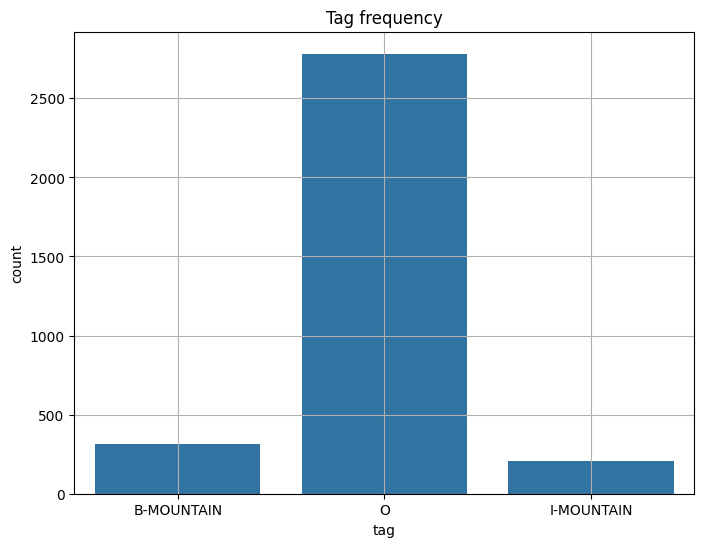

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='tag', data=data)
plt.title("Tag frequency")
plt.xlabel("tag")
plt.ylabel("count")
plt.grid()
%matplotlib inline
plt.show()

# Preprocessing

In [5]:
tags = list(set(data["tag"].values))
words = ["<PAD>", "<UNK>"] + list(set(data["word"].values))

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# transform sentences & tags
numerical_sentences = []
numerical_tags = []

for sentence in sentences:
    _words, _tags = zip(*sentence)  # Separate words and tags
    numerical_sentences.append([word2idx.get(word, word2idx["<UNK>"]) for word in _words])
    numerical_tags.append([tag2idx[tag] for tag in _tags])

In [ ]:
# dataset class used in model training
class NERDataset(Dataset):
    def __init__(self, sentences, tags, padding=True, pad_idx=None):
        self.sentences = sentences
        self.tags = tags
        self.padding = padding
        self.max_len = max(len(sentence) for sentence in sentences)
        self.pad_idx = pad_idx
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if (self.padding):
            sentence = self.sentences[idx]
            tag = self.tags[idx]    
            padded_sentence = sentence + [self.pad_idx] * (self.max_len - len(sentence))
            padded_tag = tag + [tag2idx["O"]] * (self.max_len - len(tag)) 
            return torch.tensor(padded_sentence), torch.tensor(padded_tag)

        return torch.tensor(self.sentences[idx]), torch.tensor(self.tags[idx])

train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    numerical_sentences, numerical_tags, test_size=0.2, random_state=42
)

train_dataset = NERDataset(train_sentences, train_tags, pad_idx=0)
test_dataset = NERDataset(test_sentences, test_tags, pad_idx=0)

print(f"Training size: {len(train_dataset)}")
print(f"Testing size: {len(test_dataset)}")

Training size: 260
Testing size: 65


# Training

Let's train some sample model.

In [ ]:
vocab_size = len(word2idx)
output_dim = len(tag2idx)
pad_idx = word2idx["<PAD>"]

model = LSTM_CRF_Model(
    vocab_size=vocab_size,
    embedding_dim=output_dim,
    lstm_hidden_sizes=[64, 128, 32], 
    output_dim=10,
    pad_idx=0,
    lstm_dropout_rates=[0.1] * 2,
    lstm_batchnorms=[nn.BatchNorm1d] * 1,
)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)

c:\Users\Admin\quantum_task\ner\model.py:23: UserWarning:

Length of lstm_dropout_rates does not match lstm_hidden_sizes. Padding with 0.0.

c:\Users\Admin\quantum_task\ner\model.py:27: UserWarning:

Length of lstm_batchnorms does not match lstm_hidden_sizes. Padding with None.



Note: dataset size is extremely small, unexpected results could be achieved, model is trained as an illustration.

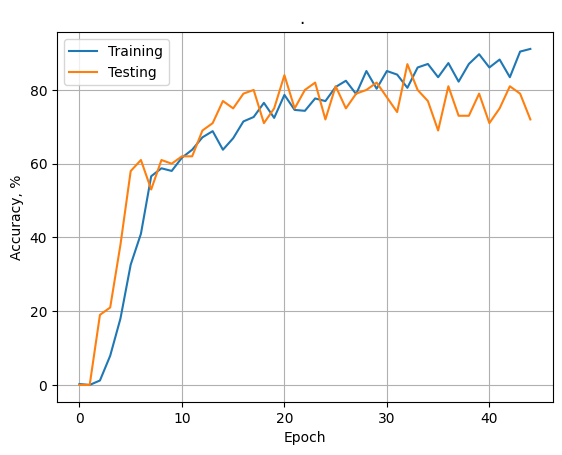

In [9]:
training_loop(
    model=model, 
    optimizer=optimizer, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset,
    output=False,
    epochs=45,
)

In [10]:
torch.save(model, 'rnn_model.pth')

# Optuna fine-tuning

We use optuna to optimize hyperparameters of the model. 

In [8]:
import optuna

vocab_size = len(word2idx)
output_dim = len(tag2idx)
pad_idx = word2idx["<PAD>"]

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [12]:
def objective(trial):
    num_layers = trial.suggest_int(f"num_of_lstm_layers", 1, 8, 2)
    lstm_hidden_sizes = [
        trial.suggest_int(f"lstm_hidden_size_{i}", 16, 128, step=16) for i in range(num_layers)  # Example for 3 layers
    ]
    
    lstm_dropout_rates = [
        trial.suggest_uniform(f"lstm_dropout_rate_{i}", 0.0, 0.5) for i in range(num_layers)  # Example for 3 layers
    ]
    
    lstm_batchnorms = [
        trial.suggest_categorical(f"lstm_batchnorm_{i}", [None, nn.BatchNorm1d]) for i in range(num_layers)  # Example for 3 layers
    ]
    
    model = LSTM_CRF_Model(
        vocab_size=vocab_size,
        embedding_dim=output_dim,
        lstm_hidden_sizes=lstm_hidden_sizes,
        output_dim=10,
        pad_idx=0,
        lstm_dropout_rates=lstm_dropout_rates,
        lstm_batchnorms=lstm_batchnorms
    )
    
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for epoch in range(15):
        for sentences, tags in train_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            optimizer.zero_grad()
            loss = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device), tags=tags)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, tags in val_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            predicted = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device))
            padded_predicted = [sublist + [0] * (tags.shape[1] - len(sublist)) for sublist in predicted]
            padded_predicted = torch.tensor(padded_predicted)
            tags_flat = tags.view(-1).to(device)
            predicted = padded_predicted.view(-1).to(device)
            mask = (tags_flat != 0)
            predicted = predicted[mask]
            tags_flat = tags_flat[mask]

            correct += (predicted == tags_flat).sum().item()
            total += tags_flat.size(0)

    val_accuracy = correct / total * 100
    return val_accuracy

In [10]:
def progress_callback(study, trial):
    print(f"Trial {trial.number}; Value = {trial.value}")


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, callbacks=[progress_callback])

print("Best trial:")
print(study.best_trial.params)

[I 2024-12-05 01:04:42,739] A new study created in memory with name: no-name-ad8c26f5-2841-448c-9669-f7f866e819d4
C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\618672021.py:2: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:708: UserWarning:

The distribution is specified by [1, 8] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 7].

C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\618672021.py:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float

Trial 0; Value = 60.962566844919785


[I 2024-12-05 01:06:54,560] Trial 1 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 80, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.21426401537737078, 'lstm_dropout_rate_1': 0.07101640477331345, 'lstm_dropout_rate_2': 0.05620127105678541, 'lstm_dropout_rate_3': 0.1461299653385758, 'lstm_dropout_rate_4': 0.3779140941517291, 'lstm_dropout_rate_5': 0.4354244733164595, 'lstm_dropout_rate_6': 0.22572826349814662, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 1; Value = 58.6096256684492


[I 2024-12-05 01:07:29,287] Trial 2 finished with value: 63.20855614973262 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 112, 'lstm_hidden_size_1': 48, 'lstm_hidden_size_2': 112, 'lstm_dropout_rate_0': 0.10585103369827298, 'lstm_dropout_rate_1': 0.29669997811026794, 'lstm_dropout_rate_2': 0.1018750538470698, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None}. Best is trial 1 with value: 58.6096256684492.


Trial 2; Value = 63.20855614973262


[I 2024-12-05 01:08:22,678] Trial 3 finished with value: 62.35294117647059 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 128, 'lstm_hidden_size_3': 48, 'lstm_hidden_size_4': 64, 'lstm_dropout_rate_0': 0.37898480136790724, 'lstm_dropout_rate_1': 0.15357393562075333, 'lstm_dropout_rate_2': 0.18077656576476836, 'lstm_dropout_rate_3': 0.1200989757320684, 'lstm_dropout_rate_4': 0.1302698754459719, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 3; Value = 62.35294117647059


[I 2024-12-05 01:08:58,202] Trial 4 finished with value: 61.81818181818181 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 112, 'lstm_hidden_size_1': 128, 'lstm_hidden_size_2': 48, 'lstm_dropout_rate_0': 0.10606259555594705, 'lstm_dropout_rate_1': 0.1588549080775003, 'lstm_dropout_rate_2': 0.08725990629359054, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 4; Value = 61.81818181818181


[I 2024-12-05 01:09:29,866] Trial 5 finished with value: 63.101604278074866 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 96, 'lstm_hidden_size_1': 48, 'lstm_hidden_size_2': 64, 'lstm_dropout_rate_0': 0.371539908854232, 'lstm_dropout_rate_1': 0.4304399558744766, 'lstm_dropout_rate_2': 0.26775409866269445, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 5; Value = 63.101604278074866


[I 2024-12-05 01:10:20,389] Trial 6 finished with value: 62.99465240641712 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 48, 'lstm_hidden_size_2': 112, 'lstm_hidden_size_3': 48, 'lstm_hidden_size_4': 96, 'lstm_dropout_rate_0': 0.3251635837609182, 'lstm_dropout_rate_1': 0.47708062609789686, 'lstm_dropout_rate_2': 0.4858042223918126, 'lstm_dropout_rate_3': 0.1415631330100195, 'lstm_dropout_rate_4': 0.2364069454199988, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': None}. Best is trial 1 with value: 58.6096256684492.


Trial 6; Value = 62.99465240641712


[I 2024-12-05 01:11:30,401] Trial 7 finished with value: 61.81818181818181 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 128, 'lstm_hidden_size_1': 16, 'lstm_hidden_size_2': 112, 'lstm_hidden_size_3': 16, 'lstm_hidden_size_4': 16, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.490464199337174, 'lstm_dropout_rate_1': 0.30684575664859143, 'lstm_dropout_rate_2': 0.3561900204333876, 'lstm_dropout_rate_3': 0.14160605080496697, 'lstm_dropout_rate_4': 0.3426732272853407, 'lstm_dropout_rate_5': 0.4955978934133175, 'lstm_dropout_rate_6': 0.024779593119206467, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': None}. Best is trial 1 with value: 58.6096256684492.


Trial 7; Value = 61.81818181818181


[I 2024-12-05 01:11:46,551] Trial 8 finished with value: 60.320855614973254 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 128, 'lstm_dropout_rate_0': 0.22770681906216034, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 8; Value = 60.320855614973254


[I 2024-12-05 01:12:17,881] Trial 9 finished with value: 62.67379679144385 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 112, 'lstm_hidden_size_1': 48, 'lstm_hidden_size_2': 48, 'lstm_dropout_rate_0': 0.011520188631301831, 'lstm_dropout_rate_1': 0.06269578308529211, 'lstm_dropout_rate_2': 0.05901545788024959, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 9; Value = 62.67379679144385


[I 2024-12-05 01:13:28,281] Trial 10 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 80, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.22229189584434977, 'lstm_dropout_rate_1': 0.00930789675030963, 'lstm_dropout_rate_2': 0.018000202059488657, 'lstm_dropout_rate_3': 0.33912040135884614, 'lstm_dropout_rate_4': 0.49555485426417356, 'lstm_dropout_rate_5': 0.461375327576421, 'lstm_dropout_rate_6': 0.1592739960502348, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 1 with value: 58.6096256684492.


Trial 10; Value = 58.6096256684492


[I 2024-12-05 01:14:33,610] Trial 11 finished with value: 58.50267379679145 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.21626628244414967, 'lstm_dropout_rate_1': 0.0036419677442859205, 'lstm_dropout_rate_2': 0.001994621847330083, 'lstm_dropout_rate_3': 0.34517395929623484, 'lstm_dropout_rate_4': 0.4998645827346872, 'lstm_dropout_rate_5': 0.47175570985936177, 'lstm_dropout_rate_6': 0.16001547026809895, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 11 with value: 58.50267379679145.


Trial 11; Value = 58.50267379679145


[I 2024-12-05 01:15:38,815] Trial 12 finished with value: 58.39572192513369 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.15235451427515867, 'lstm_dropout_rate_1': 0.10135052377283527, 'lstm_dropout_rate_2': 0.17831034588817896, 'lstm_dropout_rate_3': 0.4851494024358517, 'lstm_dropout_rate_4': 0.49864130498712245, 'lstm_dropout_rate_5': 0.3396816028911935, 'lstm_dropout_rate_6': 0.190395287341483, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 12; Value = 58.39572192513369


[I 2024-12-05 01:16:25,903] Trial 13 finished with value: 59.893048128342244 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 48, 'lstm_dropout_rate_0': 0.13616391722746893, 'lstm_dropout_rate_1': 0.15486950688957557, 'lstm_dropout_rate_2': 0.1729666699574215, 'lstm_dropout_rate_3': 0.49907446812574274, 'lstm_dropout_rate_4': 0.49609503827557083, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 12 with value: 58.39572192513369.


Trial 13; Value = 59.893048128342244


[I 2024-12-05 01:43:07,958] Trial 14 finished with value: 58.50267379679145 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 128, 'lstm_hidden_size_5': 64, 'lstm_hidden_size_6': 48, 'lstm_dropout_rate_0': 0.1584464428824361, 'lstm_dropout_rate_1': 0.033503726493761064, 'lstm_dropout_rate_2': 0.27004849802156405, 'lstm_dropout_rate_3': 0.49862396429699435, 'lstm_dropout_rate_4': 0.004250599216070128, 'lstm_dropout_rate_5': 0.27603870481416865, 'lstm_dropout_rate_6': 0.13247666032663868, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 14; Value = 58.50267379679145


[I 2024-12-05 01:43:57,304] Trial 15 finished with value: 62.03208556149733 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 128, 'lstm_hidden_size_2': 80, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 96, 'lstm_dropout_rate_0': 0.029700228528590916, 'lstm_dropout_rate_1': 0.10355100694908492, 'lstm_dropout_rate_2': 0.16059486898087855, 'lstm_dropout_rate_3': 0.3597358083229709, 'lstm_dropout_rate_4': 0.3902082498612633, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 12 with value: 58.39572192513369.


Trial 15; Value = 62.03208556149733


[I 2024-12-05 01:44:09,456] Trial 16 finished with value: 61.604278074866315 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 32, 'lstm_dropout_rate_0': 0.28884779115158976, 'lstm_batchnorm_0': None}. Best is trial 12 with value: 58.39572192513369.


Trial 16; Value = 61.604278074866315


[I 2024-12-05 01:45:12,127] Trial 17 finished with value: 59.35828877005348 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 48, 'lstm_hidden_size_5': 64, 'lstm_hidden_size_6': 80, 'lstm_dropout_rate_0': 0.16766094160425535, 'lstm_dropout_rate_1': 0.21970341749481798, 'lstm_dropout_rate_2': 0.007478881099170942, 'lstm_dropout_rate_3': 0.2597283400235205, 'lstm_dropout_rate_4': 0.43565177344414324, 'lstm_dropout_rate_5': 0.07295409948516729, 'lstm_dropout_rate_6': 0.4942889342057418, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 17; Value = 59.35828877005348


[I 2024-12-05 01:46:06,012] Trial 18 finished with value: 60.53475935828877 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 80, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 112, 'lstm_dropout_rate_0': 0.06302342346602383, 'lstm_dropout_rate_1': 0.0002022956811004728, 'lstm_dropout_rate_2': 0.3249581322148742, 'lstm_dropout_rate_3': 0.4301245193672246, 'lstm_dropout_rate_4': 0.30592543662144855, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 12 with value: 58.39572192513369.


Trial 18; Value = 60.53475935828877


[I 2024-12-05 01:47:17,053] Trial 19 finished with value: 58.50267379679145 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 128, 'lstm_hidden_size_6': 64, 'lstm_dropout_rate_0': 0.29433561286119353, 'lstm_dropout_rate_1': 0.09765822127709643, 'lstm_dropout_rate_2': 0.20847936153286073, 'lstm_dropout_rate_3': 0.013127791031739, 'lstm_dropout_rate_4': 0.4542920759211845, 'lstm_dropout_rate_5': 0.3549116408390789, 'lstm_dropout_rate_6': 0.3178886634094561, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': None, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 19; Value = 58.50267379679145


[I 2024-12-05 01:48:09,344] Trial 20 finished with value: 61.71122994652406 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 48, 'lstm_hidden_size_3': 64, 'lstm_hidden_size_4': 80, 'lstm_dropout_rate_0': 0.18229774524671982, 'lstm_dropout_rate_1': 0.21477137971435195, 'lstm_dropout_rate_2': 0.12019759858326684, 'lstm_dropout_rate_3': 0.275842442576216, 'lstm_dropout_rate_4': 0.29906613454254805, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 20; Value = 61.71122994652406


[I 2024-12-05 01:49:16,898] Trial 21 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 128, 'lstm_hidden_size_5': 64, 'lstm_hidden_size_6': 48, 'lstm_dropout_rate_0': 0.1585186649963515, 'lstm_dropout_rate_1': 0.03941582705681549, 'lstm_dropout_rate_2': 0.265676310532618, 'lstm_dropout_rate_3': 0.4822205818769065, 'lstm_dropout_rate_4': 0.011033711413075464, 'lstm_dropout_rate_5': 0.24926141658155415, 'lstm_dropout_rate_6': 0.12262166410882143, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 12 with value: 58.39572192513369.


Trial 21; Value = 58.6096256684492


[I 2024-12-05 01:50:22,825] Trial 22 finished with value: 58.288770053475936 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 112, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.09217253831899225, 'lstm_dropout_rate_1': 0.1105917720671204, 'lstm_dropout_rate_2': 0.3059886348011978, 'lstm_dropout_rate_3': 0.41986291031273015, 'lstm_dropout_rate_4': 0.0016602189312286825, 'lstm_dropout_rate_5': 0.2779519354171924, 'lstm_dropout_rate_6': 0.1291948398558753, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 22; Value = 58.288770053475936


[I 2024-12-05 01:51:32,234] Trial 23 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 112, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.08568002553336575, 'lstm_dropout_rate_1': 0.11822993151124467, 'lstm_dropout_rate_2': 0.32748795493651883, 'lstm_dropout_rate_3': 0.4189760043801928, 'lstm_dropout_rate_4': 0.16537087410468715, 'lstm_dropout_rate_5': 0.3435082917345588, 'lstm_dropout_rate_6': 0.19833540515314407, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 23; Value = 58.6096256684492


[I 2024-12-05 02:05:05,716] Trial 24 finished with value: 59.786096256684495 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 112, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.27267486540282015, 'lstm_dropout_rate_1': 0.3799452973021864, 'lstm_dropout_rate_2': 0.4133346112050408, 'lstm_dropout_rate_3': 0.4126881320227358, 'lstm_dropout_rate_4': 0.10531184766419904, 'lstm_dropout_rate_5': 0.1609390296874138, 'lstm_dropout_rate_6': 0.043698833254387726, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 24; Value = 59.786096256684495


[I 2024-12-05 02:05:50,062] Trial 25 finished with value: 60.106951871657756 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 128, 'lstm_hidden_size_2': 64, 'lstm_hidden_size_3': 64, 'lstm_hidden_size_4': 96, 'lstm_dropout_rate_0': 0.053319236646791286, 'lstm_dropout_rate_1': 0.17939724838859866, 'lstm_dropout_rate_2': 0.22639804071514175, 'lstm_dropout_rate_3': 0.31167424319292103, 'lstm_dropout_rate_4': 0.4304663282110185, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 22 with value: 58.288770053475936.


Trial 25; Value = 60.106951871657756


[I 2024-12-05 02:06:46,950] Trial 26 finished with value: 60.0 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.1868061949362142, 'lstm_dropout_rate_1': 0.07481955675988892, 'lstm_dropout_rate_2': 0.2956478859858381, 'lstm_dropout_rate_3': 0.4341136423330138, 'lstm_dropout_rate_4': 0.05610710238679223, 'lstm_dropout_rate_5': 0.3879659553925, 'lstm_dropout_rate_6': 0.09665138344021199, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 26; Value = 60.0


[I 2024-12-05 02:07:34,803] Trial 27 finished with value: 61.1764705882353 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 48, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 112, 'lstm_dropout_rate_0': 0.12171058777780643, 'lstm_dropout_rate_1': 0.11806936477971137, 'lstm_dropout_rate_2': 0.14088328444430245, 'lstm_dropout_rate_3': 0.38330254208973197, 'lstm_dropout_rate_4': 0.2231221005013641, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 22 with value: 58.288770053475936.


Trial 27; Value = 61.1764705882353


[I 2024-12-05 02:08:37,030] Trial 28 finished with value: 60.42780748663101 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 48, 'lstm_hidden_size_5': 32, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.2552391206936402, 'lstm_dropout_rate_1': 0.03297715340066145, 'lstm_dropout_rate_2': 0.3870894221379121, 'lstm_dropout_rate_3': 0.3069223902057583, 'lstm_dropout_rate_4': 0.3937948256676228, 'lstm_dropout_rate_5': 0.3124769154003359, 'lstm_dropout_rate_6': 0.27871374943018234, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_5': None, 'lstm_batchnorm_6': None}. Best is trial 22 with value: 58.28877

Trial 28; Value = 60.42780748663101


[I 2024-12-05 02:09:45,209] Trial 29 finished with value: 58.39572192513369 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 48, 'lstm_hidden_size_6': 96, 'lstm_dropout_rate_0': 0.07403008858681237, 'lstm_dropout_rate_1': 0.19929625330525463, 'lstm_dropout_rate_2': 0.0576715207517598, 'lstm_dropout_rate_3': 0.22043691922168301, 'lstm_dropout_rate_4': 0.3064041516783086, 'lstm_dropout_rate_5': 0.1870321937870603, 'lstm_dropout_rate_6': 0.20633749068249357, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 29; Value = 58.39572192513369


[I 2024-12-05 02:10:52,451] Trial 30 finished with value: 59.35828877005348 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 48, 'lstm_hidden_size_6': 96, 'lstm_dropout_rate_0': 0.05888746946966352, 'lstm_dropout_rate_1': 0.2073973823107637, 'lstm_dropout_rate_2': 0.22599783678833932, 'lstm_dropout_rate_3': 0.20441900583057532, 'lstm_dropout_rate_4': 0.28148409512225414, 'lstm_dropout_rate_5': 0.1800431154310263, 'lstm_dropout_rate_6': 0.2515416334125346, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 22 with value: 58.288770053475936.


Trial 30; Value = 59.35828877005348


[I 2024-12-05 02:12:04,010] Trial 31 finished with value: 57.43315508021391 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.13741676337026534, 'lstm_dropout_rate_1': 0.24527260804347548, 'lstm_dropout_rate_2': 0.04109538810105923, 'lstm_dropout_rate_3': 0.19374200894759164, 'lstm_dropout_rate_4': 0.4770015262258989, 'lstm_dropout_rate_5': 0.19204854878751515, 'lstm_dropout_rate_6': 0.18250798237355548, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 31; Value = 57.43315508021391


[I 2024-12-05 02:13:14,974] Trial 32 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 48, 'lstm_hidden_size_6': 128, 'lstm_dropout_rate_0': 0.0023856892858452605, 'lstm_dropout_rate_1': 0.2538733269892894, 'lstm_dropout_rate_2': 0.05420506047338623, 'lstm_dropout_rate_3': 0.19671818762329543, 'lstm_dropout_rate_4': 0.4502179892779709, 'lstm_dropout_rate_5': 0.1849598062121692, 'lstm_dropout_rate_6': 0.19975021642043594, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 32; Value = 58.6096256684492


[I 2024-12-05 02:14:25,047] Trial 33 finished with value: 59.465240641711226 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 96, 'lstm_dropout_rate_0': 0.08785996410681798, 'lstm_dropout_rate_1': 0.33667800359601974, 'lstm_dropout_rate_2': 0.08376143497228684, 'lstm_dropout_rate_3': 0.21550681702330968, 'lstm_dropout_rate_4': 0.3260062166882832, 'lstm_dropout_rate_5': 0.11250872215175584, 'lstm_dropout_rate_6': 0.07071451264082118, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 33; Value = 59.465240641711226


[I 2024-12-05 06:40:11,032] Trial 34 finished with value: 60.0 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 16, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.1395001444969089, 'lstm_dropout_rate_1': 0.18767859159881659, 'lstm_dropout_rate_2': 0.03235158154846579, 'lstm_dropout_rate_3': 0.0799590299095391, 'lstm_dropout_rate_4': 0.2637155184711648, 'lstm_dropout_rate_5': 0.2169245219922853, 'lstm_dropout_rate_6': 0.18352458375382502, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 34; Value = 60.0


[I 2024-12-05 06:42:31,290] Trial 35 finished with value: 61.925133689839576 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 112, 'lstm_dropout_rate_0': 0.0914601092566569, 'lstm_dropout_rate_1': 0.2505350022228319, 'lstm_dropout_rate_2': 0.12811723653166768, 'lstm_dropout_rate_3': 0.2199989162355501, 'lstm_dropout_rate_4': 0.07608535993443802, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 31 with value: 57.43315508021391.


Trial 35; Value = 61.925133689839576


[I 2024-12-05 06:46:06,282] Trial 36 finished with value: 61.71122994652406 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 96, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 128, 'lstm_hidden_size_5': 48, 'lstm_hidden_size_6': 96, 'lstm_dropout_rate_0': 0.03604989717274165, 'lstm_dropout_rate_1': 0.2598493171108297, 'lstm_dropout_rate_2': 0.0647585150591933, 'lstm_dropout_rate_3': 0.461271934916368, 'lstm_dropout_rate_4': 0.16342248116160746, 'lstm_dropout_rate_5': 0.12215413105938339, 'lstm_dropout_rate_6': 0.26584975020819257, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNor

Trial 36; Value = 61.71122994652406


[I 2024-12-05 06:48:33,780] Trial 37 finished with value: 59.465240641711226 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 80, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 48, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 64, 'lstm_dropout_rate_0': 0.1073480199078704, 'lstm_dropout_rate_1': 0.13345755902101178, 'lstm_dropout_rate_2': 0.11764427531773099, 'lstm_dropout_rate_3': 0.17529022192247318, 'lstm_dropout_rate_4': 0.19478684358669612, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 31 with value: 57.43315508021391.


Trial 37; Value = 59.465240641711226


[I 2024-12-05 07:29:22,929] Trial 38 finished with value: 61.283422459893046 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 96, 'lstm_hidden_size_1': 32, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 64, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 128, 'lstm_dropout_rate_0': 0.13344805290952966, 'lstm_dropout_rate_1': 0.2820658109156589, 'lstm_dropout_rate_2': 0.2043730703295165, 'lstm_dropout_rate_3': 0.08866845025903008, 'lstm_dropout_rate_4': 0.36514218389018044, 'lstm_dropout_rate_5': 0.0031388149851110936, 'lstm_dropout_rate_6': 0.11652230997271196, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 38; Value = 61.283422459893046


[I 2024-12-05 07:30:12,913] Trial 39 finished with value: 62.139037433155075 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 64, 'lstm_dropout_rate_0': 0.19105014267229903, 'lstm_dropout_rate_1': 0.17981293156953637, 'lstm_dropout_rate_2': 0.10148213948714571, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None}. Best is trial 31 with value: 57.43315508021391.


Trial 39; Value = 62.139037433155075


[I 2024-12-05 07:33:43,180] Trial 40 finished with value: 61.1764705882353 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 128, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 64, 'lstm_hidden_size_6': 80, 'lstm_dropout_rate_0': 0.07383904443526314, 'lstm_dropout_rate_1': 0.34473726643907276, 'lstm_dropout_rate_2': 0.03710767753279223, 'lstm_dropout_rate_3': 0.24705332970471403, 'lstm_dropout_rate_4': 0.4136321645972491, 'lstm_dropout_rate_5': 0.22476356159373495, 'lstm_dropout_rate_6': 0.209567207616172, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_5': None, 'lstm_batchnorm_6': None}. Best is trial 31 with value: 57.4331

Trial 40; Value = 61.1764705882353


[I 2024-12-05 07:37:07,213] Trial 41 finished with value: 59.144385026737964 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.2250434831919216, 'lstm_dropout_rate_1': 0.06757685483789046, 'lstm_dropout_rate_2': 0.0023654648572412618, 'lstm_dropout_rate_3': 0.3945041414975706, 'lstm_dropout_rate_4': 0.46796476455034086, 'lstm_dropout_rate_5': 0.29806500775382766, 'lstm_dropout_rate_6': 0.1521082492821564, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 41; Value = 59.144385026737964


[I 2024-12-05 07:40:12,343] Trial 42 finished with value: 57.86096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.11700858372629376, 'lstm_dropout_rate_1': 0.13809746314874957, 'lstm_dropout_rate_2': 0.03943321445798692, 'lstm_dropout_rate_3': 0.4520894094066078, 'lstm_dropout_rate_4': 0.47509701360135004, 'lstm_dropout_rate_5': 0.4212153991507834, 'lstm_dropout_rate_6': 0.171732428479341, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 42; Value = 57.86096256684492


[I 2024-12-05 07:43:02,851] Trial 43 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 32, 'lstm_hidden_size_4': 32, 'lstm_hidden_size_5': 128, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.10911105595568682, 'lstm_dropout_rate_1': 0.1428192514490212, 'lstm_dropout_rate_2': 0.0790799269332761, 'lstm_dropout_rate_3': 0.4571254228373195, 'lstm_dropout_rate_4': 0.4743489229072908, 'lstm_dropout_rate_5': 0.3724820337631143, 'lstm_dropout_rate_6': 0.1734868146028886, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 43; Value = 58.6096256684492


[I 2024-12-05 09:07:17,577] Trial 44 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 64, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 48, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 48, 'lstm_dropout_rate_0': 0.04010380865600535, 'lstm_dropout_rate_1': 0.09131346518031278, 'lstm_dropout_rate_2': 0.039638728867223916, 'lstm_dropout_rate_3': 0.16475152780513813, 'lstm_dropout_rate_4': 0.36173916555401686, 'lstm_dropout_rate_5': 0.4041480392729232, 'lstm_dropout_rate_6': 0.23488963920672562, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 44; Value = 58.6096256684492


[I 2024-12-05 09:08:17,461] Trial 45 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.4927519826031723, 'lstm_dropout_rate_1': 0.16473312457050415, 'lstm_dropout_rate_2': 0.1506978810781518, 'lstm_dropout_rate_3': 0.4608744244000498, 'lstm_dropout_rate_4': 0.4142381851835527, 'lstm_dropout_rate_5': 0.32389516239436345, 'lstm_dropout_rate_6': 0.0894896373197851, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315

Trial 45; Value = 58.6096256684492


[I 2024-12-05 09:08:42,523] Trial 46 finished with value: 59.03743315508021 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 48, 'lstm_dropout_rate_0': 0.1465654787012772, 'lstm_dropout_rate_1': 0.2304684269369585, 'lstm_dropout_rate_2': 0.4424725525947306, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None}. Best is trial 31 with value: 57.43315508021391.


Trial 46; Value = 59.03743315508021


[I 2024-12-05 09:09:23,328] Trial 47 finished with value: 60.0 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 64, 'lstm_dropout_rate_0': 0.11785811969358875, 'lstm_dropout_rate_1': 0.127254246863729, 'lstm_dropout_rate_2': 0.09544398409711244, 'lstm_dropout_rate_3': 0.290395618934303, 'lstm_dropout_rate_4': 0.47723480107046656, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 31 with value: 57.43315508021391.


Trial 47; Value = 60.0


[I 2024-12-05 09:10:20,572] Trial 48 finished with value: 60.53475935828877 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 48, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 48, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 64, 'lstm_dropout_rate_0': 0.19702794571343418, 'lstm_dropout_rate_1': 0.19702988758715062, 'lstm_dropout_rate_2': 0.2909787710868123, 'lstm_dropout_rate_3': 0.1094384827808015, 'lstm_dropout_rate_4': 0.22803780538687457, 'lstm_dropout_rate_5': 0.2237175031404256, 'lstm_dropout_rate_6': 0.28605502437599456, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.433

Trial 48; Value = 60.53475935828877


[I 2024-12-05 09:11:20,799] Trial 49 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 64, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.4620929047984032, 'lstm_dropout_rate_1': 0.16135379022001048, 'lstm_dropout_rate_2': 0.026048316525806747, 'lstm_dropout_rate_3': 0.23750607362079582, 'lstm_dropout_rate_4': 0.494165033098101, 'lstm_dropout_rate_5': 0.4205010440983239, 'lstm_dropout_rate_6': 0.14133921884315004, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 49; Value = 58.6096256684492


[I 2024-12-05 09:11:33,550] Trial 50 finished with value: 62.24598930481283 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 96, 'lstm_dropout_rate_0': 0.014049875018803198, 'lstm_batchnorm_0': None}. Best is trial 31 with value: 57.43315508021391.


Trial 50; Value = 62.24598930481283


[I 2024-12-05 09:12:30,508] Trial 51 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.17280817402126292, 'lstm_dropout_rate_1': 0.04601586428610011, 'lstm_dropout_rate_2': 0.0587491501068837, 'lstm_dropout_rate_3': 0.33844300216393425, 'lstm_dropout_rate_4': 0.4989954612551157, 'lstm_dropout_rate_5': 0.49904031782294667, 'lstm_dropout_rate_6': 0.17220996541030048, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 51; Value = 58.6096256684492


[I 2024-12-05 09:13:30,298] Trial 52 finished with value: 59.893048128342244 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.2168034575965843, 'lstm_dropout_rate_1': 0.23605940719084312, 'lstm_dropout_rate_2': 0.010554903241589704, 'lstm_dropout_rate_3': 0.361102265943344, 'lstm_dropout_rate_4': 0.4433955800222483, 'lstm_dropout_rate_5': 0.264388918595476, 'lstm_dropout_rate_6': 0.208638309475711, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': None, 'lstm_batchnorm_6': None}. Best is trial 31 with value: 57.43315508021391.


Trial 52; Value = 59.893048128342244


[I 2024-12-05 09:14:26,618] Trial 53 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 128, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 96, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.2465421540017317, 'lstm_dropout_rate_1': 0.0856502733823059, 'lstm_dropout_rate_2': 0.07615496934747919, 'lstm_dropout_rate_3': 0.4492401708898636, 'lstm_dropout_rate_4': 0.4753958203967937, 'lstm_dropout_rate_5': 0.45685313888508955, 'lstm_dropout_rate_6': 0.15448877689104643, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 53; Value = 58.6096256684492


[I 2024-12-05 09:15:20,445] Trial 54 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 16, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.1554964086256659, 'lstm_dropout_rate_1': 0.019262442030362807, 'lstm_dropout_rate_2': 0.0489218678882825, 'lstm_dropout_rate_3': 0.49660125061673116, 'lstm_dropout_rate_4': 0.4154087894969455, 'lstm_dropout_rate_5': 0.4571817174402185, 'lstm_dropout_rate_6': 0.23847232540262908, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 54; Value = 58.6096256684492


[I 2024-12-05 09:16:20,106] Trial 55 finished with value: 58.18181818181818 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.13586377320744747, 'lstm_dropout_rate_1': 0.05686930155960085, 'lstm_dropout_rate_2': 0.0007424580054988805, 'lstm_dropout_rate_3': 0.39630352961275217, 'lstm_dropout_rate_4': 0.4619241981093575, 'lstm_dropout_rate_5': 0.2846632477903709, 'lstm_dropout_rate_6': 0.4219283294690523, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 55; Value = 58.18181818181818


[I 2024-12-05 11:01:25,241] Trial 56 finished with value: 62.67379679144385 and parameters: {'num_of_lstm_layers': 5, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 128, 'lstm_hidden_size_4': 112, 'lstm_dropout_rate_0': 0.09455438889496981, 'lstm_dropout_rate_1': 0.11212987404101224, 'lstm_dropout_rate_2': 0.018761781433231463, 'lstm_dropout_rate_3': 0.39087010896727337, 'lstm_dropout_rate_4': 0.45539554642369956, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None}. Best is trial 31 with value: 57.43315508021391.


Trial 56; Value = 62.67379679144385


[I 2024-12-05 11:02:25,058] Trial 57 finished with value: 60.21390374331551 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 112, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 96, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 32, 'lstm_dropout_rate_0': 0.07254111331236537, 'lstm_dropout_rate_1': 0.48976514168624613, 'lstm_dropout_rate_2': 0.3568211322328592, 'lstm_dropout_rate_3': 0.4793795795560156, 'lstm_dropout_rate_4': 0.33743659810579346, 'lstm_dropout_rate_5': 0.2949279206750968, 'lstm_dropout_rate_6': 0.3697765810421386, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_4': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': None}. Best is trial 31 with value: 57.43315508021391.


Trial 57; Value = 60.21390374331551


[I 2024-12-05 11:03:21,108] Trial 58 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 48, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 80, 'lstm_hidden_size_4': 64, 'lstm_hidden_size_5': 112, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.12452012048867032, 'lstm_dropout_rate_1': 0.05982069043536133, 'lstm_dropout_rate_2': 0.1828775155082427, 'lstm_dropout_rate_3': 0.4055773292272934, 'lstm_dropout_rate_4': 0.38799613835074753, 'lstm_dropout_rate_5': 0.2576428973611692, 'lstm_dropout_rate_6': 0.35151452468485234, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 58; Value = 58.6096256684492


[I 2024-12-05 11:04:20,603] Trial 59 finished with value: 58.6096256684492 and parameters: {'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 96, 'lstm_hidden_size_2': 96, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 48, 'lstm_hidden_size_5': 96, 'lstm_hidden_size_6': 16, 'lstm_dropout_rate_0': 0.3192777138378644, 'lstm_dropout_rate_1': 0.14591577420777294, 'lstm_dropout_rate_2': 0.332027793723735, 'lstm_dropout_rate_3': 0.4396152284520037, 'lstm_dropout_rate_4': 0.4286445949495226, 'lstm_dropout_rate_5': 0.1983321846889072, 'lstm_dropout_rate_6': 0.48387450600566956, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 31 with value: 57.43315508021391.


Trial 59; Value = 58.6096256684492
Best trial:
{'num_of_lstm_layers': 7, 'lstm_hidden_size_0': 16, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 16, 'lstm_hidden_size_3': 112, 'lstm_hidden_size_4': 80, 'lstm_hidden_size_5': 80, 'lstm_hidden_size_6': 112, 'lstm_dropout_rate_0': 0.13741676337026534, 'lstm_dropout_rate_1': 0.24527260804347548, 'lstm_dropout_rate_2': 0.04109538810105923, 'lstm_dropout_rate_3': 0.19374200894759164, 'lstm_dropout_rate_4': 0.4770015262258989, 'lstm_dropout_rate_5': 0.19204854878751515, 'lstm_dropout_rate_6': 0.18250798237355548, 'lstm_batchnorm_0': None, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None, 'lstm_batchnorm_4': None, 'lstm_batchnorm_5': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_6': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}


Each study includes only 15 epochs, which is presumably not enough for a reasonable result. Weird results could be expected.

In [ ]:
# get params from the best trial
layers = [study.best_trial.params[f'lstm_hidden_size_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]
dropouts = [study.best_trial.params[f'lstm_dropout_rate_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]
bns = [study.best_trial.params[f'lstm_batchnorm_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]

model = LSTM_CRF_Model(
    vocab_size=vocab_size,
    embedding_dim=output_dim,
    lstm_hidden_sizes=layers,
    output_dim=10,
    pad_idx=0,
    lstm_dropout_rates=dropouts,
    lstm_batchnorms=bns
)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)

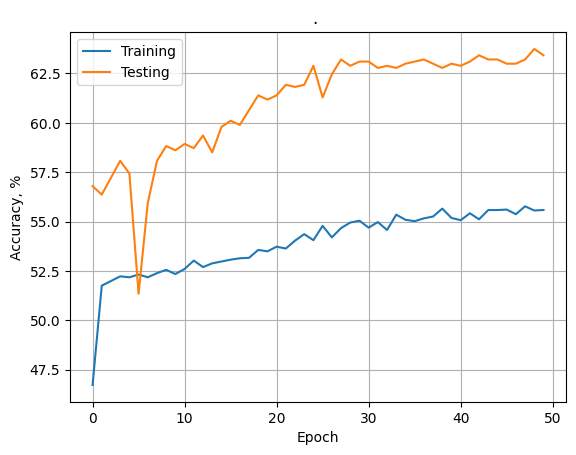

In [ ]:
# training the best trial with more epochs
training_loop(
    model=model, 
    optimizer=optimizer, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset,
    output=False,
    epochs=50,
)

Results are indeed weird. Let's conduct another study with params closer to our initial attempt, which looked better.

In [19]:
def objective(trial):
    num_layers = trial.suggest_int(f"num_of_lstm_layers", 1, 4, 1)
    lstm_hidden_sizes = [
        trial.suggest_int(f"lstm_hidden_size_{i}", 16, 128, step=16) for i in range(num_layers)  # Example for 3 layers
    ]
    
    lstm_dropout_rates = [
        trial.suggest_uniform(f"lstm_dropout_rate_{i}", 0.0, 0.3) for i in range(num_layers)  # Example for 3 layers
    ]
    
    lstm_batchnorms = [
        trial.suggest_categorical(f"lstm_batchnorm_{i}", [None, nn.BatchNorm1d]) for i in range(num_layers)  # Example for 3 layers
    ]
    
    model = LSTM_CRF_Model(
        vocab_size=vocab_size,
        embedding_dim=output_dim,
        lstm_hidden_sizes=lstm_hidden_sizes,
        output_dim=10,
        pad_idx=0,
        lstm_dropout_rates=lstm_dropout_rates,
        lstm_batchnorms=lstm_batchnorms
    )
    
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for epoch in range(30):
        for sentences, tags in train_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            optimizer.zero_grad()
            loss = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device), tags=tags)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, tags in val_loader:
            sentences, tags = sentences.to(device), tags.to(device)
            predicted = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device))
            padded_predicted = [sublist + [0] * (tags.shape[1] - len(sublist)) for sublist in predicted]
            padded_predicted = torch.tensor(padded_predicted)
            tags_flat = tags.view(-1).to(device)
            predicted = padded_predicted.view(-1).to(device)
            mask = (tags_flat != 0)
            predicted = predicted[mask]
            tags_flat = tags_flat[mask]

            correct += (predicted == tags_flat).sum().item()
            total += tags_flat.size(0)

    val_accuracy = correct / total * 100
    return val_accuracy

In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, callbacks=[progress_callback])

print("Best trial:")
print(study.best_trial.params)

[I 2024-12-05 13:41:51,712] A new study created in memory with name: no-name-fe5e107b-e243-406b-980b-cdae374dcc0c


C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\2776863533.py:2: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\Admin\AppData\Local\Temp\ipykernel_53816\2776863533.py:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.batchnorm.BatchNorm1d'> which is of type type.

[I 2024-12-05 13:42:34,633] Trial 0 finished with value: 62.56684491978609 and parameters: {'num_of_lstm_layers': 2, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 128, 'lstm_dropout_rate_0': 0.17188705290584413, 'lstm_dropout_rate_1':

Trial 0; Value = 62.56684491978609


[I 2024-12-05 13:43:41,285] Trial 1 finished with value: 62.56684491978609 and parameters: {'num_of_lstm_layers': 4, 'lstm_hidden_size_0': 64, 'lstm_hidden_size_1': 32, 'lstm_hidden_size_2': 32, 'lstm_hidden_size_3': 32, 'lstm_dropout_rate_0': 0.21343205092861062, 'lstm_dropout_rate_1': 0.093129437097848, 'lstm_dropout_rate_2': 0.017158855631594437, 'lstm_dropout_rate_3': 0.14456321870250424, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 0 with value: 62.56684491978609.


Trial 1; Value = 62.56684491978609


[I 2024-12-05 13:44:28,855] Trial 2 finished with value: 63.74331550802139 and parameters: {'num_of_lstm_layers': 2, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 128, 'lstm_dropout_rate_0': 0.10429724680297447, 'lstm_dropout_rate_1': 0.12841245670676377, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None}. Best is trial 0 with value: 62.56684491978609.


Trial 2; Value = 63.74331550802139


[I 2024-12-05 13:45:07,210] Trial 3 finished with value: 62.45989304812834 and parameters: {'num_of_lstm_layers': 2, 'lstm_hidden_size_0': 32, 'lstm_hidden_size_1': 32, 'lstm_dropout_rate_0': 0.2333520062577495, 'lstm_dropout_rate_1': 0.11056666105410408, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 3 with value: 62.45989304812834.


Trial 3; Value = 62.45989304812834


[I 2024-12-05 13:45:28,328] Trial 4 finished with value: 61.604278074866315 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 16, 'lstm_dropout_rate_0': 0.15681679032919804, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 4 with value: 61.604278074866315.


Trial 4; Value = 61.604278074866315


[I 2024-12-05 13:46:07,010] Trial 5 finished with value: 63.20855614973262 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 112, 'lstm_dropout_rate_0': 0.13639015254443723, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 4 with value: 61.604278074866315.


Trial 5; Value = 63.20855614973262


[I 2024-12-05 13:48:01,738] Trial 6 finished with value: 62.780748663101605 and parameters: {'num_of_lstm_layers': 4, 'lstm_hidden_size_0': 112, 'lstm_hidden_size_1': 80, 'lstm_hidden_size_2': 112, 'lstm_hidden_size_3': 48, 'lstm_dropout_rate_0': 0.16794814950192063, 'lstm_dropout_rate_1': 0.1331143027532589, 'lstm_dropout_rate_2': 0.15175820277986712, 'lstm_dropout_rate_3': 0.18539097315833425, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None}. Best is trial 4 with value: 61.604278074866315.


Trial 6; Value = 62.780748663101605


[I 2024-12-05 13:48:35,382] Trial 7 finished with value: 62.56684491978609 and parameters: {'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 64, 'lstm_dropout_rate_0': 0.051310587530635686, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}. Best is trial 4 with value: 61.604278074866315.


Trial 7; Value = 62.56684491978609


[I 2024-12-05 13:50:10,120] Trial 8 finished with value: 62.99465240641712 and parameters: {'num_of_lstm_layers': 4, 'lstm_hidden_size_0': 80, 'lstm_hidden_size_1': 16, 'lstm_hidden_size_2': 48, 'lstm_hidden_size_3': 96, 'lstm_dropout_rate_0': 0.2288835229432023, 'lstm_dropout_rate_1': 0.07591992994871333, 'lstm_dropout_rate_2': 0.12123550678949924, 'lstm_dropout_rate_3': 0.1944045465862375, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None, 'lstm_batchnorm_3': None}. Best is trial 4 with value: 61.604278074866315.


Trial 8; Value = 62.99465240641712


[I 2024-12-05 13:51:39,320] Trial 9 finished with value: 62.45989304812834 and parameters: {'num_of_lstm_layers': 3, 'lstm_hidden_size_0': 112, 'lstm_hidden_size_1': 128, 'lstm_hidden_size_2': 96, 'lstm_dropout_rate_0': 0.236760570002716, 'lstm_dropout_rate_1': 0.08100138975087848, 'lstm_dropout_rate_2': 0.14352455146898827, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>, 'lstm_batchnorm_1': None, 'lstm_batchnorm_2': None}. Best is trial 4 with value: 61.604278074866315.


Trial 9; Value = 62.45989304812834
Best trial:
{'num_of_lstm_layers': 1, 'lstm_hidden_size_0': 16, 'lstm_dropout_rate_0': 0.15681679032919804, 'lstm_batchnorm_0': <class 'torch.nn.modules.batchnorm.BatchNorm1d'>}


In [22]:
study.best_trial.params

{'num_of_lstm_layers': 1,
 'lstm_hidden_size_0': 16,
 'lstm_dropout_rate_0': 0.15681679032919804,
 'lstm_batchnorm_0': torch.nn.modules.batchnorm.BatchNorm1d}

In [ ]:
# get params from the best trial
layers = [study.best_trial.params[f'lstm_hidden_size_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]
dropouts = [study.best_trial.params[f'lstm_dropout_rate_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]
bns = [study.best_trial.params[f'lstm_batchnorm_{i}'] for i in range (study.best_trial.params['num_of_lstm_layers'])]

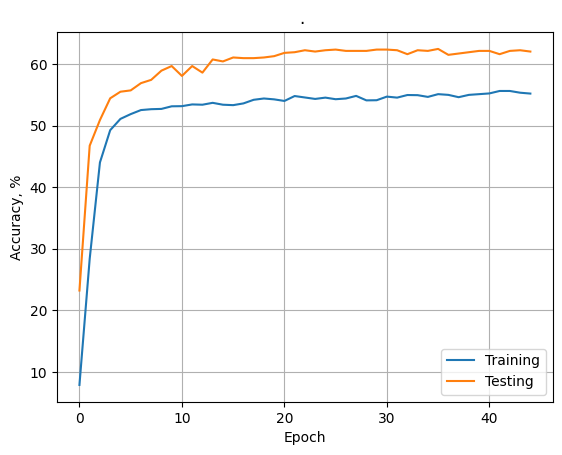

In [25]:
vocab_size = len(word2idx)
output_dim = len(tag2idx)
pad_idx = word2idx["<PAD>"]

model = LSTM_CRF_Model(
    vocab_size=vocab_size,
    embedding_dim=output_dim,
    # lstm_hidden_sizes=[16, 32, 16], 
    lstm_hidden_sizes=layers, 
    output_dim=10,
    pad_idx=0,
    lstm_dropout_rates=dropouts,
    lstm_batchnorms=bns,
)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)

training_loop(
    model=model, 
    optimizer=optimizer, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset,
    output=False,
    epochs=45,
)

In [28]:
torch.save(model, 'rnn_model_optuna.pth')